In [1]:
# !pip install graphviz
# !pip install dask
# !pip install toolz
# !pip3 install cloudpickle
# !pip install folium
# !pip install -U scikit-learn
# !pip install gpxpy
# !pip install xgboost

In [2]:
import dask.dataframe as dd
import pandas as pd
import folium 
import datetime 
import time 
import numpy as np

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams

import gpxpy.geo 

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import xgboost as xgb
import scipy

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

from dask.diagnostics import ProgressBar
ProgressBar().register()

In [3]:
month = dd.read_csv("yellow_tripdata_2015-01.csv")
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [4]:
print(len(month.columns))

19


## Performance Metrics:
* Mean Absolute Percentage Error
* Mean Squared Error

## Data Cleaning:

In [5]:
month.head(5)

[########################################] | 100% Completed |  2.1s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


### 1. Pickup Latitude & Longitude
* NYC is bounded by (40.5774, -74.15) & (40.9176, -73.7004)

In [6]:
outlier_pickup_locations = month[(month["pickup_latitude"] <= 40.5774) | (month["pickup_longitude"] <= -74.15) | \
                                 (month["pickup_latitude"] >= 40.9176) | (month["pickup_longitude"] >= -73.7004)]
outlier_pickup_locations.head(5)

[########################################] | 100% Completed |  2.4s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
31,2,2015-01-15 19:05:43,2015-01-15 19:05:44,2,0.01,0.0,0.0,5,N,0.0,0.0,1,60.0,0.0,0.0,0.00,0.00,0.3,60.30
61,1,2015-01-04 13:44:52,2015-01-04 13:56:49,1,2.50,0.0,0.0,1,N,0.0,0.0,1,11.0,0.0,0.5,2.35,0.00,0.0,14.15
66,2,2015-01-04 13:44:52,2015-01-04 13:49:03,1,0.85,0.0,0.0,1,N,0.0,0.0,2,5.5,0.0,0.5,0.00,0.00,0.3,6.30
157,1,2015-01-15 09:47:00,2015-01-15 10:00:07,1,1.00,0.0,0.0,1,N,0.0,0.0,2,10.0,0.0,0.5,0.00,0.00,0.3,10.80
159,1,2015-01-15 09:47:02,2015-01-15 10:17:47,3,8.30,0.0,0.0,1,N,0.0,0.0,1,27.5,0.0,0.5,10.00,5.33,0.3,43.63


In [7]:
outliers_map = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_outlier_locations = outlier_pickup_locations.head(1000)
for i,j in sample_outlier_locations.iterrows():
    if(int(j["pickup_latitude"]) != 0):
        folium.Marker(list((j["pickup_latitude"], j["pickup_longitude"]))).add_to(outliers_map)
outliers_map

[########################################] | 100% Completed |  2.6s


### 2. Dropoff Latitude & Longitude

In [8]:
outlier_pickup_locations = month[(month["dropoff_latitude"] <= 40.5774) | (month["dropoff_longitude"] <= -74.15) | \
                                 (month["dropoff_latitude"] >= 40.9176) | (month["dropoff_longitude"] >= -73.7004)]

outliers_map = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_outlier_locations = outlier_pickup_locations.head(1000)
for i,j in sample_outlier_locations.iterrows():
    if(int(j["dropoff_latitude"]) != 0):
        folium.Marker(list((j["dropoff_latitude"], j["dropoff_longitude"]))).add_to(outliers_map)
outliers_map

[########################################] | 100% Completed |  4.7s


### 3. Trip Duration
* According to NYC Taxi Comission Regulations, the maximum allowed trip duration in a 24 hour interval is 12 hours.

In [9]:
print(month[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].head(5))
print(month["tpep_pickup_datetime"].head(5).values)

[########################################] | 100% Completed |  5.9s
  tpep_pickup_datetime tpep_dropoff_datetime
0  2015-01-15 19:05:39   2015-01-15 19:23:42
1  2015-01-10 20:33:38   2015-01-10 20:53:28
2  2015-01-10 20:33:38   2015-01-10 20:43:41
3  2015-01-10 20:33:39   2015-01-10 20:35:31
4  2015-01-10 20:33:39   2015-01-10 20:52:58
[########################################] | 100% Completed |  3.0s
['2015-01-15 19:05:39' '2015-01-10 20:33:38' '2015-01-10 20:33:38'
 '2015-01-10 20:33:39' '2015-01-10 20:33:39']


In [10]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s,"%Y-%m-%d %H:%M:%S").timetuple())

In [11]:
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    duration_pickup = [convert_to_unix(t) for t in duration["tpep_pickup_datetime"].values]
    duration_dropoff = [convert_to_unix(t) for t in duration["tpep_dropoff_datetime"].values]
    durations = (np.array(duration_dropoff) - np.array(duration_pickup))/float(60)
    df_new = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    df_new['trip_times'] = durations
    df_new['pickup_times'] = duration_pickup
    df_new['speed'] = 60*(df_new['trip_distance']/df_new['trip_times'])
    return df_new

### Calculating percentile trip durations

In [12]:
df_with_durations = return_with_trip_times(month)
df_with_durations = df_with_durations[(df_with_durations["pickup_latitude"] > 40.5774) & \
                                      (df_with_durations["pickup_longitude"] > -74.15) & \
                                      (df_with_durations["pickup_latitude"] < 40.9176) & \
                                      (df_with_durations["pickup_longitude"] < -73.7004)]

df_with_durations = df_with_durations[(df_with_durations["dropoff_latitude"] > 40.5774) & \
                                      (df_with_durations["dropoff_longitude"] > -74.15) & \
                                      (df_with_durations["dropoff_latitude"] < 40.9176) & \
                                      (df_with_durations["dropoff_longitude"] < -73.7004)]

[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 38.1s


In [13]:
trip_times = df_with_durations["trip_times"].values
trip_times = np.sort(trip_times, axis=None)
for i in range(0, 100, 10):
    print("{} percentile value is {}".format(i, trip_times[int(len(trip_times)*(float(i)/100))]))
print ("100 percentile value is ",trip_times[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8666666666666667
20 percentile value is 5.4
30 percentile value is 6.833333333333333
40 percentile value is 8.316666666666666
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.266666666666667
80 percentile value is 17.583333333333332
90 percentile value is 23.333333333333332
100 percentile value is  79925.35


In [14]:
for i in range(90,100):
    print("{} percentile value is {}".format(i,trip_times[int(len(trip_times)*(float(i)/100))]))
print ("100 percentile value is ",trip_times[-1])

90 percentile value is 23.333333333333332
91 percentile value is 24.233333333333334
92 percentile value is 25.233333333333334
93 percentile value is 26.4
94 percentile value is 27.75
95 percentile value is 29.383333333333333
96 percentile value is 31.466666666666665
97 percentile value is 34.21666666666667
98 percentile value is 38.4
99 percentile value is 46.4
100 percentile value is  79925.35


In [15]:
df_with_durations = df_with_durations[(df_with_durations["trip_times"] > 1) & (df_with_durations["trip_times"] < 720)]
df_with_durations.head(5)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421320e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420893e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420893e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420893e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420893e+09,9.318378


### 4. Speed

In [16]:
df_with_durations['speed'] = 60* (df_with_durations['trip_distance']/df_with_durations['trip_times'])
sns.boxplot(y="speed", data=df_with_durations)
plt.show()

<IPython.core.display.Javascript object>

In [17]:
df = df_with_durations["speed"].values
df = np.sort(df, axis=None)
for i in range(0, 100, 10):
    print("{} percentile value is {}".format(i, df[int(len(df)*(float(i)/100))]))
print("100 percentile value is ", df[-1])

0 percentile value is 0.0
10 percentile value is 6.410322580645161
20 percentile value is 7.808219178082191
30 percentile value is 8.925619834710744
40 percentile value is 9.975000000000001
50 percentile value is 11.060240963855422
60 percentile value is 12.272727272727273
70 percentile value is 13.774834437086096
80 percentile value is 15.92307692307692
90 percentile value is 20.074349442379184
100 percentile value is  192857142.85714284


In [18]:
for i in range(90, 100, 1):
    print("{} percentile value is {}".format(i, df[int(len(df)*(float(i)/100))]))
print("100 percentile value is ", df[-1])   

90 percentile value is 20.074349442379184
91 percentile value is 20.78460399703923
92 percentile value is 21.599999999999998
93 percentile value is 22.546972860125262
94 percentile value is 23.64510166358595
95 percentile value is 24.950495049504948
96 percentile value is 26.53179190751445
97 percentile value is 28.519805420430856
98 percentile value is 31.20840630472854
99 percentile value is 35.33450704225352
100 percentile value is  192857142.85714284


In [19]:
for i in np.arange(99.0, 100.0, 0.1):
    print("{} percentile value is {}".format(i, df[int(len(df)*(float(i)/100))]))
print("100 percentile value is ", df[-1])   

99.0 percentile value is 35.33450704225352
99.1 percentile value is 35.895953757225435
99.19999999999999 percentile value is 36.49681528662421
99.29999999999998 percentile value is 37.15736040609137
99.39999999999998 percentile value is 37.91044776119402
99.49999999999997 percentile value is 38.74871794871795
99.59999999999997 percentile value is 39.719431279620856
99.69999999999996 percentile value is 40.912423625254576
99.79999999999995 percentile value is 42.437086092715234
99.89999999999995 percentile value is 44.81186783546865
100 percentile value is  192857142.85714284


In [20]:
df_with_durations = df_with_durations[(df_with_durations["speed"] > 0) & (df_with_durations["speed"] < 45.31)]
df_with_durations.head(5)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421320e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420893e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420893e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420893e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420893e+09,9.318378


In [21]:
sum(df_with_durations["speed"].values)/float(len(df_with_durations["speed"]))

12.417004473079007

Average Speed is 12.45 miles/hr meaning that a driver can cover roughly 2 miles in 10 mins"

### 5. Distance

In [22]:
sns.boxplot(y="trip_distance", data=df_with_durations)
plt.show()

<IPython.core.display.Javascript object>

In [23]:
var = df_with_durations["trip_distance"].values
var = np.sort(var, axis=None)
for i in range(0, 100, 10):
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

0 percentile value is 0.01
10 percentile value is 0.67
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.7
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.58
90 percentile value is 5.9
100 percentile value is  258.9


In [24]:
for i in range(90, 100, 1):
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

90 percentile value is 5.9
91 percentile value is 6.39
92 percentile value is 6.96
93 percentile value is 7.7
94 percentile value is 8.6
95 percentile value is 9.46
96 percentile value is 10.4
97 percentile value is 11.77
98 percentile value is 15.45
99 percentile value is 18.0
100 percentile value is  258.9


In [25]:
for i in np.arange(99, 100, .1):
    print("{} percentile value is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ", var[-1])

99.0 percentile value is 18.0
99.1 percentile value is 18.2
99.19999999999999 percentile value is 18.42
99.29999999999998 percentile value is 18.69
99.39999999999998 percentile value is 18.97
99.49999999999997 percentile value is 19.3
99.59999999999997 percentile value is 19.7
99.69999999999996 percentile value is 20.3
99.79999999999995 percentile value is 20.97
99.89999999999995 percentile value is 22.0
100 percentile value is  258.9


In [26]:
df_with_durations = df_with_durations[(df_with_durations["trip_distance"] > 0) & (df_with_durations["trip_distance"] < 22.58)]

In [27]:
sns.boxplot(y="trip_distance", data=df_with_durations)
plt.show()

<IPython.core.display.Javascript object>

### 6. Trip Fare

In [28]:
sns.boxplot(y="total_amount", data=df_with_durations)
plt.show()

<IPython.core.display.Javascript object>

In [29]:
var = df_with_durations["total_amount"].values
var = np.sort(var, axis=None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.35
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.2
90 percentile value is 25.5
100 percentile value is  3950611.6


In [30]:
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.5
91 percentile value is 26.8
92 percentile value is 28.8
93 percentile value is 31.0
94 percentile value is 34.13
95 percentile value is 37.6
96 percentile value is 41.4
97 percentile value is 46.36
98 percentile value is 54.8
99 percentile value is 63.36
100 percentile value is  3950611.6


In [31]:
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99 + i,var[int(len(var)*(float(99 + i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 63.36
99.1 percentile value is 65.13
99.2 percentile value is 66.13
99.3 percentile value is 68.13
99.4 percentile value is 69.6
99.5 percentile value is 69.6
99.6 percentile value is 69.73
99.7 percentile value is 69.76
99.8 percentile value is 72.35
99.9 percentile value is 72.66
100 percentile value is  3950611.6


In [32]:
plt.plot(var[:-2])
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


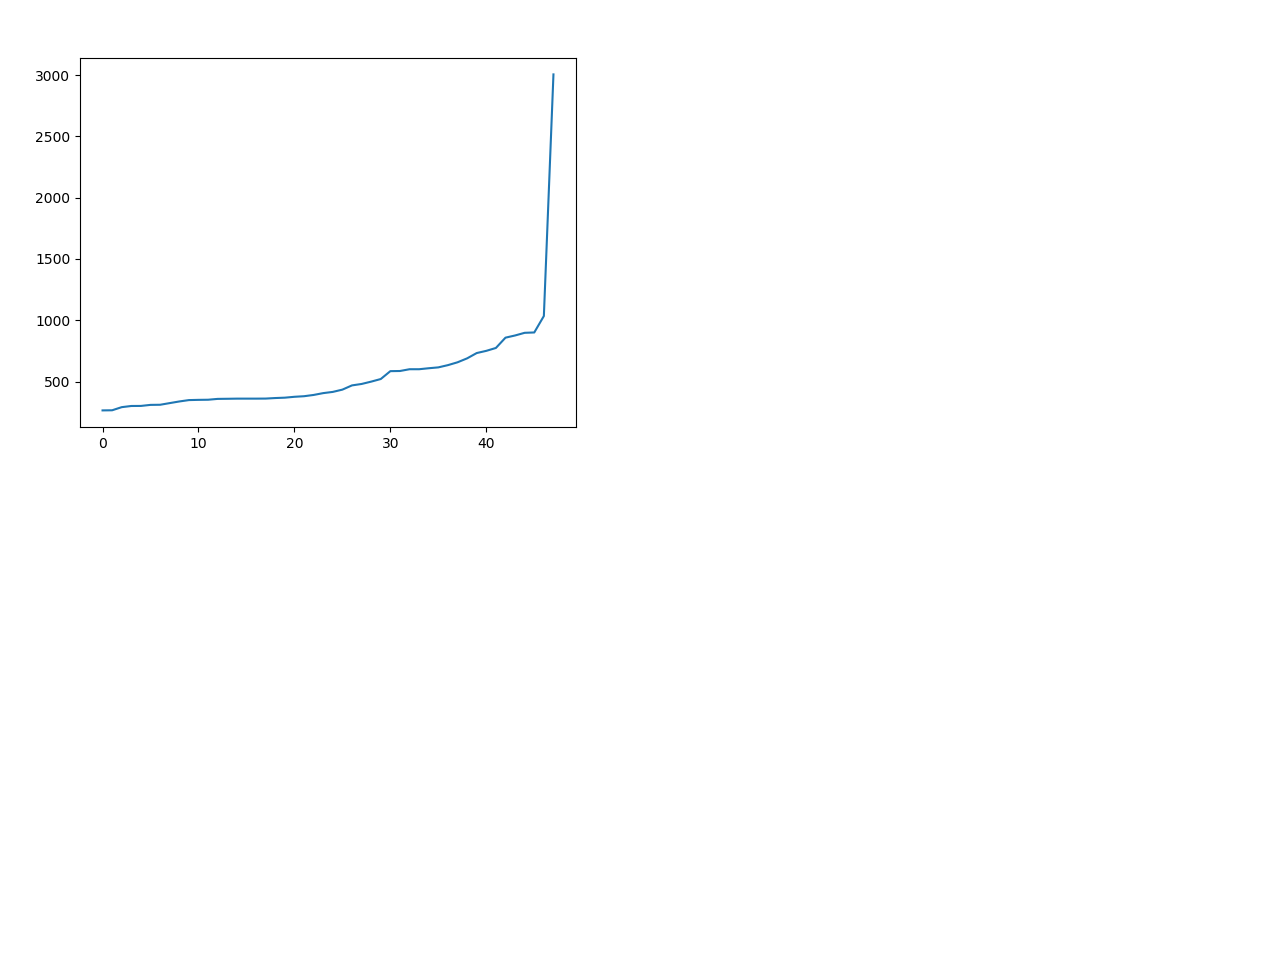

In [33]:
plt.plot(var[-50:-2])
plt.show()

In [34]:
df_with_durations = df_with_durations[(df_with_durations["total_amount"] > 0) & (df_with_durations["total_amount"] < 1000)]

In [35]:
print(df_with_durations.shape[0]/len(month))

[########################################] | 100% Completed | 42.5s
0.9681304066064548


Percentage of data left after removing all outliers = 96.8%

In [38]:
coords = df_with_durations[["pickup_latitude", "pickup_longitude"]].values
neighbours = []

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    df_with_durations['pickup_cluster'] = kmeans.predict(df_with_durations[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

for increment in range(10, 60, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)  

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 3.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 7.0 
Min inter-cluster distance =  0.8526576429868767 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.6510388293300068 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.519423461399079 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 10.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 30.0 
Min inter-cluster distance 

In [39]:
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
df_with_durations['pickup_cluster'] = kmeans.predict(df_with_durations[['pickup_latitude', 'pickup_longitude']])

<IPython.core.display.Javascript object>


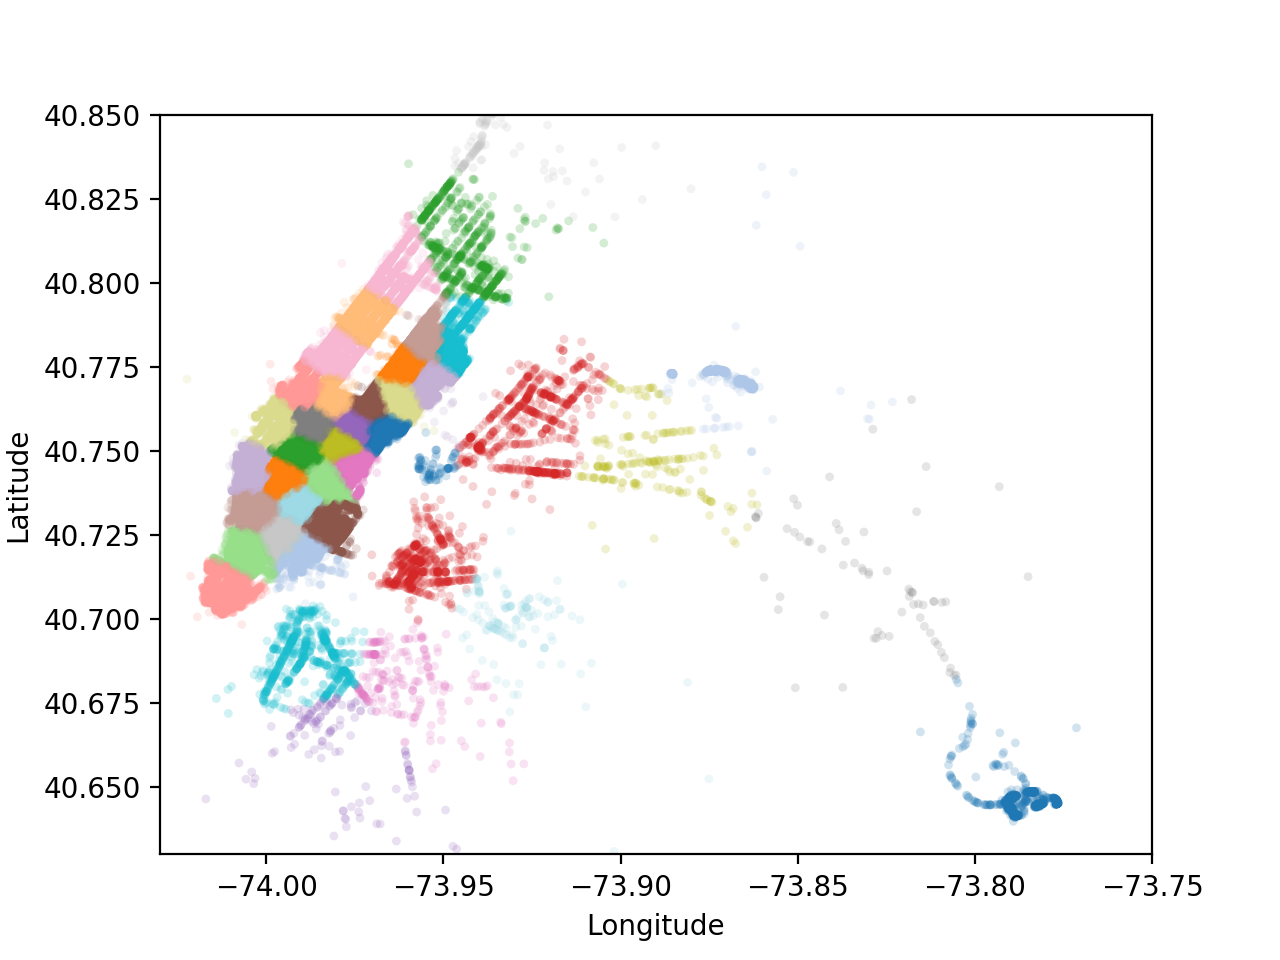

In [41]:
# Plotting The Clusters
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()
plot_clusters(df_with_durations)

In [64]:
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame, month, year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600) + 33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [67]:
jan_2015_frame = add_pickup_bins(df_with_durations, 1, 2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [68]:
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421320e+09,5.285319,9,2115
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420893e+09,9.983193,10,1404
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420893e+09,10.746269,26,1404
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420893e+09,16.071429,14,1404
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420893e+09,9.318378,21,1404


In [63]:
df_with_durations["pickup_bins"]

AttributeError: 'Series' object has no attribute 'unique_counts'